# Final Project - Machine Learning Applied to Steel Fatigue Data
Author: Hunter Kimmett


This project will involve visualizing and applying ML models to Fatigue data from various steel alloys. Fatigue life expectancy of alloys is usually estimated using Linear Regression, and for this project we will attempt to use a different model to achieve better results.

We will be attempting to match results from the paper "Exploration of data science techniques to predict fatigue strength of steel from composition and processing parameters" as seen here:

https://link.springer.com/article/10.1186/2193-9772-3-8

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 0. Function definitions

In [56]:
from sklearn.model_selection import cross_validate

def get_cross_val_scores(model, X, y, cv=7):
    '''Calculate train and validation score for regressor (model) using cross-validation
        
        score is r^2.
        
        model (sklearn classifier): Regressor to train and evaluate
        X (numpy.array or pandas.DataFrame): Feature matrix
        y (numpy.array or pandas.Series): Target vector
        
        returns: mean training r^2, mean validation r^2
    
    '''
    
    scores = cross_validate(model, X, y, cv=cv, scoring='r2', return_train_score=True)
    
    train_score = scores['train_score'].mean()
    test_score = scores['test_score'].mean()

    return train_score, test_score

In [105]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

def get_scores(model, X, y):
    '''Calculate and print scores for any model and. Scores include 
     Root Mean Squared Error, R^2, and Mean Absolute Error.
        
        model (sklearn classifier): Regressor to train and evaluate
        X (numpy.array or pandas.DataFrame): Feature matrix
        y (numpy.array or pandas.Series): Target vector
        
        returns: predicted y values
    
    '''
    
    y_pred = model.predict(X)
    rmse = mean_squared_error(y, y_pred, squared=False)
    r_sq = r2_score(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    
    print(type(model).__name__)
    print("R^2: {:.3f}".format(r_sq))
    print("Mean Absolute Error: {:.2f}".format(mae))
    print("Root Mean Squared Error: {:.2f}\n".format(rmse))
    
    return y_pred
    

## 1. Load data
Data will be imported from fatigue_dataset.xlsx

### 1.1 Prepare a pandas dataframe of all data

Data will be in stored in a pandas dataframe, `data`.

In [13]:
data = pd.read_excel("fatigue_dataset.xlsx")

data

,Sl. No.,NT,THT,THt,THQCr,CT,Ct,DT,Dt,QmT,...,S,Ni,Cr,Cu,Mo,RedRatio,dA,dB,dC,Fatigue
0,1,885,30,0,0,30,0.0,30.000,0.0,30,...,0.022,0.01,0.02,0.01,0.00,825,0.070,0.020,0.040,232
1,2,885,30,0,0,30,0.0,30.000,0.0,30,...,0.017,0.08,0.12,0.08,0.00,610,0.110,0.000,0.040,235
2,3,885,30,0,0,30,0.0,30.000,0.0,30,...,0.015,0.02,0.03,0.01,0.00,1270,0.070,0.020,0.000,235
3,4,885,30,0,0,30,0.0,30.000,0.0,30,...,0.024,0.01,0.02,0.01,0.00,1740,0.060,0.000,0.000,241
4,5,885,30,0,0,30,0.0,30.000,0.0,30,...,0.022,0.01,0.02,0.02,0.00,825,0.040,0.020,0.000,225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
432,433,930,30,0,0,930,340.2,895.812,70.2,140,...,0.024,0.02,0.91,0.01,0.15,240,0.050,0.010,0.000,1030
433,434,930,30,0,0,930,340.2,895.812,70.2,140,...,0.015,0.07,1.08,0.08,0.15,530,0.017,0.004,0.008,957
434,435,930,30,0,0,930,340.2,895.812,70.2,60,...,0.019,0.06,1.17,0.07,0.17,690,0.080,0.000,0.000,1104
435,436,930,30,0,0,930,340.2,895.812,70.2,60,...,0.024,0.02,0.91,0.01,0.15,240,0.050,0.010,0.000,1008


### 1.2 Prepare the feature matrix and target vector

Loading the fatigue data set into feature matrix `X` and target vector `y`.

Printing shape and type of `X`, `y`.

In [20]:
y = data['Fatigue']
X = data.drop(columns=['Sl. No.', 'Fatigue'])

print("Feature Matrix X dimensions: ", X.shape, "\nX Type: ", type(X))
print("Target Vector y dimensions: ", y.shape, "\ny Type: ", type(y))

Feature Matrix X dimensions:  (437, 25) 
X Type:  <class 'pandas.core.frame.DataFrame'>
Target Vector y dimensions:  (437,) 
y Type:  <class 'pandas.core.series.Series'>


## 2. Inspect the data 

### 2.1 Variations in comparable feature types

In the paper there are 3 categories of features within this dataset:
- Chemical composition - %C, %Si, %Mn, %P, %S, %Ni, %Cr, %Cu, %Mo (all in wt. %)
- Heat treatment conditions - temperature, time and other process conditions for normalizing, through-hardening, carburizing-quenching and tempering processes
- Upstream processing details - ingot size, reduction ratio, non-metallic inclusions

These features are shown defined below, as their abbreviations are the column headers for our feature matrix. We can also look at a boxplot comparing variances in these comparable features:


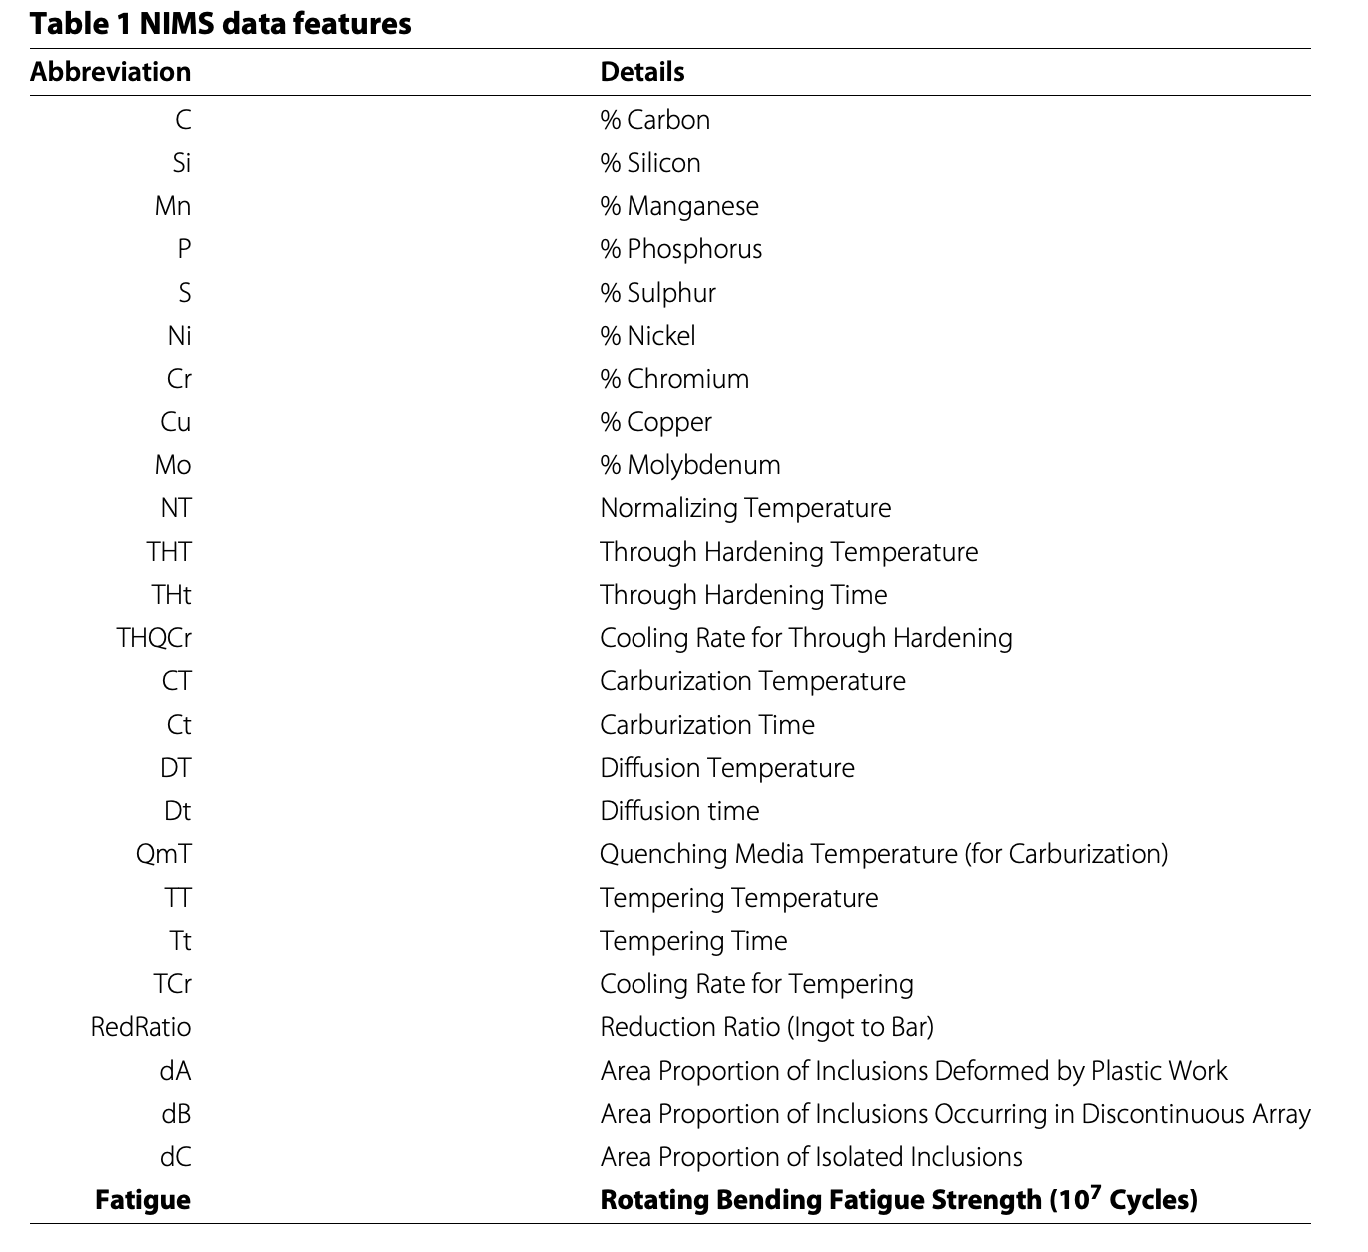

In [24]:
from IPython.display import Image
Image(filename='reference_images/feature_table.png') 

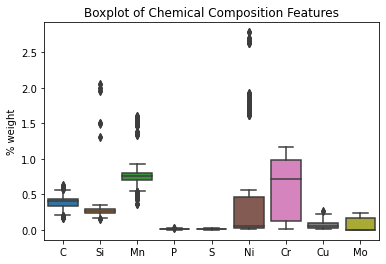

In [31]:
box_plot = sns.boxplot(data=X[['C', 'Si', 'Mn', 'P', 'S', 'Ni', 'Cr', 'Cu', 'Mo']])
box_plot.set(ylabel='% weight', title='Boxplot of Chemical Composition Features')
box_plot

From this plot we can see that the elements with the most variance are Ni and Cr. Ni, Mn Si and C have the most outlier points, while P, S, Cu and Mo are the most consistent. It is good to see consistent low data for Phosphorus and Sulfur, as these elements can significantly weaken steel.

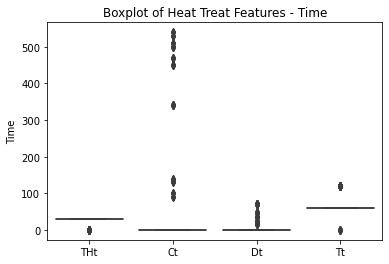

In [36]:
box_plot = sns.boxplot(data=X[['THt', 'Ct', 'Dt', 'Tt']])
box_plot.set(ylabel='Time', title='Boxplot of Heat Treat Features - Time')
box_plot

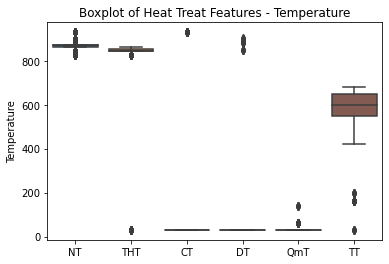

In [38]:
box_plot = sns.boxplot(data=X[['NT', 'THT', 'CT', 'DT', 'QmT', 'TT']])
box_plot.set(ylabel='Temperature', title='Boxplot of Heat Treat Features - Temperature')
box_plot

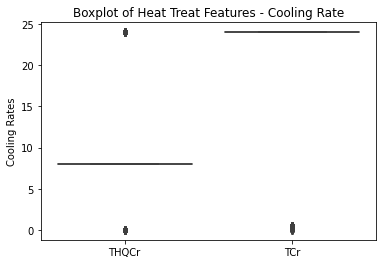

In [39]:
box_plot = sns.boxplot(data=X[['THQCr','TCr']])
box_plot.set(ylabel='Cooling Rate', title='Boxplot of Heat Treat Features - Cooling Rate')
box_plot

For heat treatments we can see that in some cases no heat treatment wsa performed at all, showing with the median CT, Ct, DT, Dt, and QmT values of zero with some outliers. Values in other categories seem to coalesce around the same vlues or range of values, showing moderate consisitency with the heat treatments used on these samples.

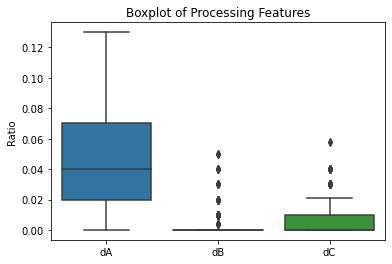

In [41]:
box_plot = sns.boxplot(data=X[['dA', 'dB', 'dC']])
box_plot.set(ylabel='Area', title='Boxplot of Processing Features - Inclusion Areas')
box_plot

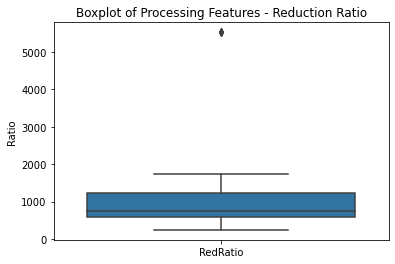

In [44]:
box_plot = sns.boxplot(data=X[['RedRatio']])
box_plot.set(ylabel='Ratio', title='Boxplot of Processing Features - Reduction Ratio')
box_plot

Processing features remain relatively consistent and within reasonable ranges, with the exception of dB, which has the median value of 0.

### 2.2 Correlation heatmap of features 

To understand if pairs of features are potentially related, contain similar information, pair-wise cross-correlation can be calculated.

Let's take a look at the correlation heatmap of our features. Since one heatmap cannot contain all this info, let's just look at the correlation between the weight% of all the alloying materials:

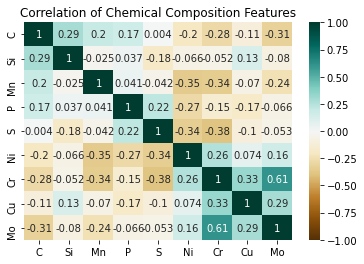

In [47]:
Xwtcorrelation = X[['C', 'Si', 'Mn', 'P', 'S', 'Ni', 'Cr', 'Cu', 'Mo']].corr()

heat_map = sns.heatmap(data=Xwtcorrelation, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heat_map.set(title='Correlation of Chemical Composition Features')
heat_map

Looks like fairly low correlation across the board, except Cr with Mo. There are also a few more minor correlations across the board but it remains quite low in most cases.

### 2.3 Histogram of target vector

Let's look at the distribution of the fatigue life of all our samples.

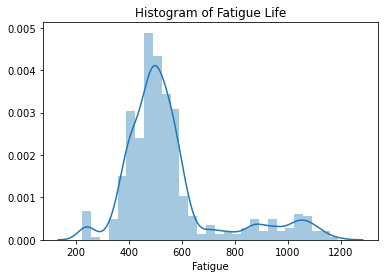

In [51]:
dist_plot = sns.distplot(a=y)
dist_plot.set(title='Histogram of Fatigue Life')
dist_plot

Looks like we have a high distribution of samples with a fatigue life of 500 * 10^7 cycles.

## 3. Create training and test sets

Using scikit-learn `train_test_split()` with parameters `random_state=37`, `test_size=0.2`, split `X` and `y` into training and test sets.

In [52]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=37, test_size=0.2)

## 4. Compare models using cross-validation

### 4.1 Model Selection

We will be using the following 3 models, similar to ones from the paper. Unfortunately many of the models from the paper are not available to use in scikit-learn, so we will be making due with models that closely match the better performing models from the paper. These are the models:

#### Linear Regression

Linear Regression was chosen because it is the standard fatigue life prediction model in use. This model performed well in the paper, boasting high R and R^2 scores. This also makes for a good base case regressor as no hyperparameter tuning is required.

#### Decision Tree Regressor

Decision Tree Regressor was chosen because it will perform most similarly to the Reduced Error Pruning Tree (REPTree) model from the paper. This model had among the highest R and R^2 scores in the paper and performed better than the Linear Regression model they used. It will be interesting to see if the scikit-learn model will be analogous to the model from the paper.


#### MLP Regressor

MLP Regressor was chosen because it will perform most similarly to the Artificial Neural Network (ANN) model from the paper. This model will likely be the most difficult to use, as I do not have much experience with Neural Networks. In the paper it performed better than Linear Regression and worse than REPTree, however this model from sickit-learn is definitely not the same as the one used in the paper. It will be intriguing to see how it performs in comparison, however expecting it to perform as well as Linear Regression may be asking too much.




### 4.2 Creating List of Models

Create a list containing a `LinearRegression()`, `DecisionTreeRegressor()` and `MLPRegressor()` objects.

Iterate this list, compute the negative root mean-squared error using the `get_cross_val_scores()` function, and print the training and validation scores with **2 decimal places**. Use 7-fold cross-validation.

In [63]:
# Importing models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor

# Creating list of models

model_list = []

model_lr = LinearRegression()
model_dr = DecisionTreeRegressor()
model_mr = MLPRegressor(max_iter=900)

model_list.append(model_lr)
model_list.append(model_dr)
model_list.append(model_mr)

# Training, testing, scoring models
for model in model_list:
    train, val = get_cross_val_scores(model, X_train, y_train)
    print(type(model).__name__, "\nTraining Score: {:.2f}\nValidation Score: {:.2f}\n".format(train, val))


LinearRegression 
Training Score: 0.97
Validation Score: 0.96

DecisionTreeRegressor 
Training Score: 1.00
Validation Score: 0.94

MLPRegressor 
Training Score: 0.91
Validation Score: 0.90



Linear regression seems to remain the best option using default parameters and is in line with results from the paper, but let's see if we can use a grid search with the DecisionTreeRegressor to find optimal hyperparameters and perhaps outperform LinearRegression.

## 5. Hyperparameter tuning using grid search 

### 5.1 Grid search for DecisionTreeRegressor

Perform grid search using `GridSearchCV` for the `DecisionTreeRegressor()`.

Grid search to use 7-fold cross-validation, and `r2` as the scoring function.

Using the following hyperparameters and values:
    
- `"criterion": ["mse", "mae"]`
- `"min_samples_split": [5, 10, 20, 40]`
- `"max_depth": [2, 6, 8, 10]`
- `"min_samples_leaf": [1, 5, 10, 20]`
- `"max_leaf_nodes": [5, 20, 100, 200]`


In [78]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor


params = {"criterion": ["mse", "mae"],
              "min_samples_split": [5, 10, 20, 40],
              "max_depth": [2, 6, 8, 10],
              "min_samples_leaf": [1, 5, 10, 20],
              "max_leaf_nodes": [5, 20, 100, 200],
              }

grid = GridSearchCV(DecisionTreeRegressor(), params, cv=7, scoring='r2', return_train_score=True)

In [79]:
grid.fit(X_train, y_train)

GridSearchCV(cv=7, estimator=DecisionTreeRegressor(),
             param_grid={'criterion': ['mse', 'mae'],
                         'max_depth': [2, 6, 8, 10],
                         'max_leaf_nodes': [5, 20, 100, 200],
                         'min_samples_leaf': [1, 5, 10, 20],
                         'min_samples_split': [5, 10, 20, 40]},
             return_train_score=True, scoring='r2')

In [80]:
print("Best parameters: {}".format(grid.best_params_))

Best parameters: {'criterion': 'mae', 'max_depth': 8, 'max_leaf_nodes': 20, 'min_samples_leaf': 1, 'min_samples_split': 20}


In [81]:
print("Best cross-validation score: {:.2f}".format(grid.best_score_))

Best cross-validation score: 0.97


Looks like that with some parameter tuning we can get comparable r^2 values to that of the paper. Let's try it on the test data now.

## 6. Retrain best model

Retraining the best estimator from the grid search and a new Linear Regression Model to compare.

In [83]:
from sklearn.tree import DecisionTreeRegressor

best_model = DecisionTreeRegressor(criterion='mae', max_depth=8, max_leaf_nodes=20,
                                   min_samples_leaf=1, min_samples_split=20)
best_model.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mae', max_depth=8, max_leaf_nodes=20,
                      min_samples_split=20)

In [84]:
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()

linear_model.fit(X_train, y_train)

LinearRegression()

## 7. Evaluate best model on training and test data
### 7.1 Calculating R-squared, Mean absolute error, and Root mean-squared error

For the retrained best estimator and linear regression, prints the scores for training and test sets.

In [97]:
print('Training Data:\n')
y_dr_pred_training = get_scores(best_model, X_train, y_train)
y_lr_pred_training = get_scores(linear_model, X_train, y_train)

print('Test Data:\n')
y_dr_pred_test = get_scores(best_model, X_test, y_test)
y_lr_pred_test = get_scores(linear_model, X_test, y_test)

Training Data:

DecisionTreeRegressor
R^2: 0.976
Mean Absolute Error: 18.69
Root Mean Squared Error: 28.68

LinearRegression
R^2: 0.970
Mean Absolute Error: 23.53
Root Mean Squared Error: 32.13

Test Data:

DecisionTreeRegressor
R^2: 0.977
Mean Absolute Error: 23.11
Root Mean Squared Error: 28.57

LinearRegression
R^2: 0.978
Mean Absolute Error: 20.82
Root Mean Squared Error: 28.40



### 7.2 Predicted vs actual fatigue life plots


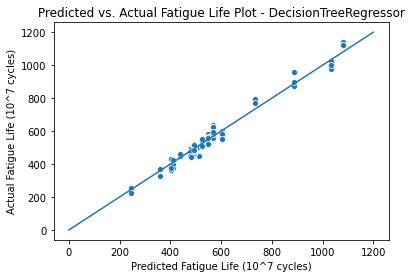

In [99]:
scatter_plot = sns.scatterplot(x=y_dr_pred_test, y=y_test)
plt.plot([0,1200],[0,1200])
scatter_plot.set(ylabel='Actual Fatigue Life (10^7 cycles)', xlabel='Predicted Fatigue Life (10^7 cycles)', 
                 title='Predicted vs. Actual Fatigue Life Plot - DecisionTreeRegressor')
scatter_plot

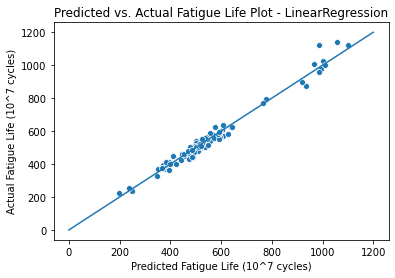

In [98]:
scatter_plot = sns.scatterplot(x=y_lr_pred_test, y=y_test)
plt.plot([0,1200],[0,1200])
scatter_plot.set(ylabel='Actual Fatigue Life (10^7 cycles)', xlabel='Predicted Fatigue Life (10^7 cycles)', 
                 title='Predicted vs. Actual Fatigue Life Plot - LinearRegression')
scatter_plot

### 7.3 Residual plots

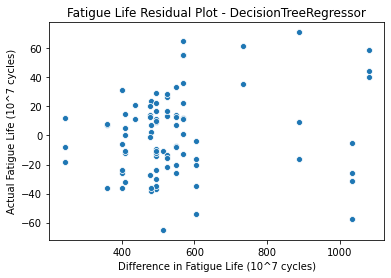

In [101]:
residual_plot = sns.scatterplot(x=y_dr_pred_test, y=(y_test-y_dr_pred_test))
residual_plot.set(ylabel='Actual Fatigue Life (10^7 cycles)', xlabel='Difference in Fatigue Life (10^7 cycles)', 
                 title='Fatigue Life Residual Plot - DecisionTreeRegressor')
residual_plot

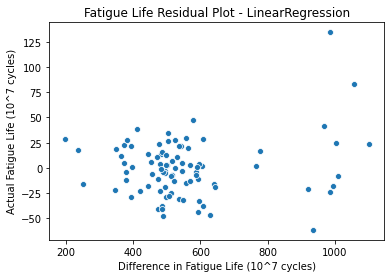

In [103]:
residual_plot = sns.scatterplot(x=y_lr_pred_test, y=(y_test-y_lr_pred_test))
residual_plot.set(ylabel='Actual Fatigue Life (10^7 cycles)', xlabel='Difference in Fatigue Life (10^7 cycles)', 
                 title='Fatigue Life Residual Plot - LinearRegression')
residual_plot

## 8. Analysis

Upon looking at the data from section 7.1, it looks like the Linear Regression model performs the best over the other models tried in this project. This is further backed up looking at 7.2 and 7.3, where the predicted data for Linear Regression is clustered more tightly around its actual value compared to the Decision Tree Regressor. 


The Decision Tree Regressor came very close to achieving the same test scores as the Linear Regression model, however it still could not perform as well. The difference between this model's performance and the one in the paper could be due to different tuning, or the model from the paper may have been different than scikit-learn's model.


It is interesting to note that when actual fatigue life exceeded around 800 cycles we can see a decrease in performance for the Linear Regression model. This could be due to the model being less flexible to outlying points, but we would need more data to come to any conclusions of its performance with these values. 


It is also interesting that the Linear Regression model from scikit-learn outperformed the paper's model, however this is likely due to the data selection for the test being easier for the model to get right.

## 9. Conclusion

While it is unfortunate that my models could not quite match the paper, there are some good conclusions that can be drawn:
- Decision Tree Regressor models can perform nearly as well as Linear Regression
- Linear Regression is a very effective way to measure fatigue life and is good as an industry standard
- I will need to look into models outside of scikit-learn to further my ML learning experience

## 10. Reflection

My final project and my initial proposal had several deviations:

#### Models Selected

Initially I wanted to try and use 5 different models that outperformed linear regression in the paper, however upon reviewing the limitations of scikit-learn I had to reduce the scope of my project, and even use different models altogether. Linear Regression stayed the same as from the paper, while Decision Tree Regressor and MLP Regressor served as analogues for Reduced Error Pruning Tree and Artificial Neural Network models respectively. I could not find a good enough analogue for the M5 Model Tree, and Multivariate Polynomial Regression was slightly too complex to fit well with my cross-validation method.

#### Scaling & Dimensionality Reduction

Unfortunately due to time constraints I was unable to implement Scaling. This was a method not used by the paper so it would have been very interesting to see the data produced. Dimensionality reduction was also a possibility but upon further research I determined that it would not be necessary for this project.


#### Further Reflection

Overall, I think for the most part the project went according to the proposal, but I am disappointed I couldn't outperform Linear Regression. This is a very tough task with R^2 scores so high as they are. If I were to repeat this project I might have used a different dataset (maybe a different material) as it would be more realistic to compare this to industry standards. A small sample size of 30-50 data points may change the effectiveness of the models used for this project.